In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
epoch_num = 2

In [7]:
working_dir = os.getcwd()
print(working_dir)

# get the parent directory
parent_dir = os.path.dirname(working_dir)
print(parent_dir)

# get the data directory
data_dir = os.path.join(parent_dir, 'data/2epochs')
print(data_dir)

/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/FL_code
/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part
/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/2epochs


In [8]:
# find all the folders in the data directory
folders = os.listdir(data_dir)
print(folders)

net_folders = []
# get the folders that contain the network
for folder in folders:
    if folder.startswith('net'):
        net_folders.append(folder)
print(net_folders)

model_path = []
# open each folder and get the .pth files
for folder in net_folders:
    folder_path = os.path.join(data_dir, folder)
    # print(folder_path)
    files = os.listdir(folder_path)
    # print(files)
    for file in files:
        if file.endswith('net_state_dict_alexnet.pth'):
            file_path = os.path.join(folder_path, file)
            # print(file_path)
            # print('*************')
            model_path.append(file_path)

print(model_path)


['net5', 'net2', 'net3', 'net4', 'combined_model_state_dict.pth', 'net1']
['net5', 'net2', 'net3', 'net4', 'net1']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/2epochs/net5/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/2epochs/net2/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/2epochs/net3/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/2epochs/net4/net_state_dict_alexnet.pth', '/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/2epochs/net1/net_state_dict_alexnet.pth']


In [9]:
import torch
from torch import nn
from d2l import torch as d2l

In [10]:
# Define your model architecture as provided
net = nn.Sequential(
    # 这里使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

model_paths = model_path

# Load all model state dictionaries
state_dicts = [torch.load(path, map_location='cpu') for path in model_paths]
# print(state_dicts[1].keys())

# Calculate the average of the parameters
avg_state_dict = {}
for key in state_dicts[0]:
    # Sum all parameters
    sum_param = sum(state_dict[key] for state_dict in state_dicts)
    # Take average
    # avg_state_dict[key] = sum_param / len(state_dicts)
    avg_state_dict[key] = sum_param
# avg_state_dict = state_dicts[0]

# Update the combined model with the averaged parameters
net.load_state_dict(avg_state_dict)

# Save the combined model
torch.save(net.state_dict(), os.path.join(data_dir, 'combined_model_state_dict.pth'))

In [11]:
# load the combined model
net.load_state_dict(torch.load(os.path.join(data_dir, 'combined_model_state_dict.pth')))

# load the test dataset
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# set the model to evaluation mode
test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
print(test_acc)

0.2226


### open the recorded acc data and the energy data

In [12]:
# find all the folders in the data directory
folders = os.listdir(data_dir)
print(folders)

data_folder = []
for name in folders:
    if name.startswith('net'):
        data_folder.append(name)
print(data_folder)

acc_data_files = []
train_acc_files = []
train_l_files = []
energy_data_files = []

# open each folder and get the .pth files
for folder in data_folder:
    folder_path = os.path.join(data_dir, folder)
    info_folder_path = os.path.join(folder_path, 'info')
    # print(folder_path)
    files = os.listdir(info_folder_path)
    print(files)
    for file in files:
        if file.startswith('acc_data'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            acc_data_files.append(file_path)
        elif file.startswith('train_acc'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            train_acc_files.append(file_path)
        elif file.startswith('train_l'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            train_l_files.append(file_path)
        elif file.startswith('energy_data_epoch'):
            file_path = os.path.join(info_folder_path, file)
            # print(file_path)
            # print('*************')
            energy_data_files.append(file_path)
            

print(acc_data_files)
print(train_acc_files)
print(train_l_files)
print(energy_data_files)

['net5', 'net2', 'net3', 'net4', 'combined_model_state_dict.pth', 'net1']
['net5', 'net2', 'net3', 'net4', 'net1']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['timeenergy_data_round.npy', 'acc_data.npy', 'energy_data_epoch.npy', 'timeenergy_data_forward.npy', 'time_data_epoch.npy', 'train_l.npy', 'train_acc.npy']
['/Users/dtjgp/Learning/Thesis/GreenAI/M1chip/Third_part/data/2epochs/net5/info/acc_data.npy', '/Use

#### acc_data_matrix

In [13]:
acc_data_matrix = np.zeros((len(acc_data_files), epoch_num))
for acc_data_file in acc_data_files:
    acc_data = np.load(acc_data_file, allow_pickle=True)
    # print(acc_data)
    acc_data_matrix[acc_data_files.index(acc_data_file), :] = acc_data
print(acc_data_matrix)  

[[0.7561 0.7917]
 [0.7431 0.7936]
 [0.7345 0.7661]
 [0.7465 0.7787]
 [0.7316 0.7863]]


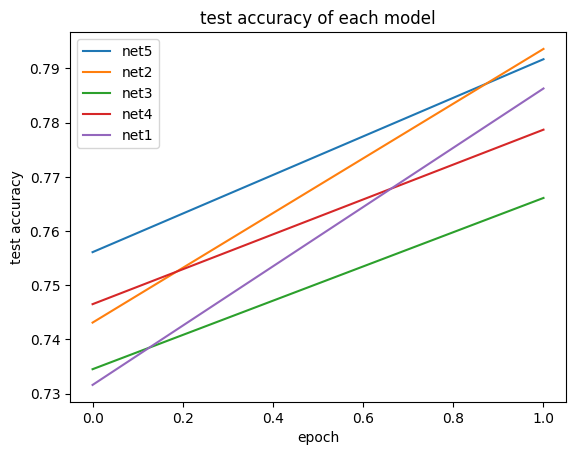

In [14]:
# plot each model's test accuracy in the same figure
plt.figure()
for i in range(acc_data_matrix.shape[0]):
    plt.plot(acc_data_matrix[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('test accuracy')
plt.title('test accuracy of each model')
# plt.savefig(os.path.join(data_dir, 'test_acc.png'))
plt.show()

#### train_acc_matrix

In [15]:
train_acc_matrix = np.zeros((len(train_acc_files), epoch_num, 469))
for train_acc_file in train_acc_files:
    train_acc = np.load(train_acc_file, allow_pickle=True)
    print(train_acc.shape)
    train_acc_matrix[train_acc_files.index(train_acc_file),:, :] = train_acc
print(train_acc_matrix)

(2, 469)
(2, 469)
(2, 469)
(2, 469)
(2, 469)
[[[0.125      0.10546875 0.09635417 ... 0.51343349 0.5138722  0.51401667]
  [0.734375   0.75       0.76041667 ... 0.75535332 0.75534188 0.75533333]]

 [[0.109375   0.08984375 0.10416667 ... 0.50613959 0.50682759 0.50701667]
  [0.7109375  0.71875    0.68229167 ... 0.75535332 0.7555422  0.75561667]]

 [[0.1171875  0.12109375 0.1171875  ... 0.45774224 0.45829995 0.45885   ]
  [0.75       0.76171875 0.73958333 ... 0.74958177 0.74968283 0.74968333]]

 [[0.125      0.10546875 0.109375   ... 0.50326218 0.5037727  0.50413333]
  [0.734375   0.72265625 0.7265625  ... 0.7563738  0.75636018 0.7564    ]]

 [[0.1015625  0.09375    0.1015625  ... 0.5042492  0.504791   0.50516667]
  [0.671875   0.6875     0.70572917 ... 0.75732736 0.75729501 0.75725   ]]]


In [16]:
train_acc_avg = np.mean(train_acc_matrix, axis=2)
print(train_acc_avg)
    

[[0.32493577 0.74140073]
 [0.31640519 0.73803421]
 [0.26796612 0.73353645]
 [0.31172458 0.74069018]
 [0.32041976 0.73959044]]


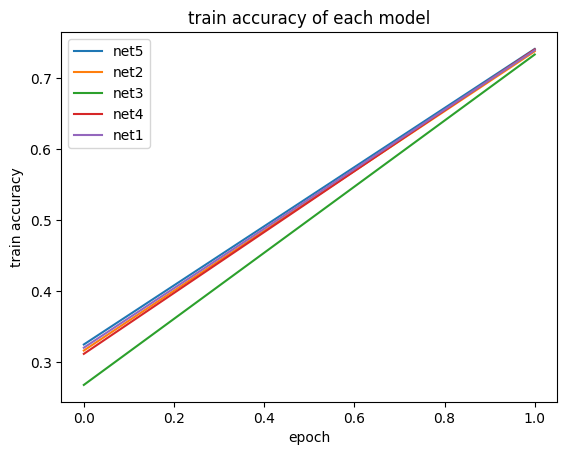

In [17]:
# plot each model's train accuracy in the same figure
plt.figure()
for i in range(train_acc_avg.shape[0]):
    plt.plot(train_acc_avg[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train accuracy')
plt.title('train accuracy of each model')
# plt.savefig(os.path.join(data_dir, 'train_acc.png'))
plt.show()

#### train_l_matrix

In [18]:
train_l_matrix = np.zeros((len(train_l_files), epoch_num, 469))
for train_l_file in train_l_files:
    train_l = np.load(train_l_file, allow_pickle=True)
    print(train_l.shape)
    train_l_matrix[train_l_files.index(train_l_file),:, :] = train_l
print(train_l_matrix)

(2, 469)
(2, 469)
(2, 469)
(2, 469)
(2, 469)
[[[2.30090714 2.30240464 2.30336205 ... 1.31770707 1.31661187 1.31607134]
  [0.6037184  0.61021081 0.63448268 ... 0.65210146 0.65196612 0.65207805]]

 [[2.3038826  2.30548644 2.30397383 ... 1.33170994 1.32999713 1.32940453]
  [0.77861857 0.77387369 0.82814829 ... 0.65029692 0.6499447  0.6498165 ]]

 [[2.30328846 2.3032701  2.30348269 ... 1.47489841 1.47339572 1.47213917]
  [0.64846456 0.61658221 0.67807643 ... 0.66642943 0.666259   0.66611652]]

 [[2.29270792 2.29867733 2.29931839 ... 1.32652527 1.32507945 1.32418325]
  [0.77455592 0.78364366 0.77970354 ... 0.64863682 0.64873227 0.64868365]]

 [[2.30076218 2.30209756 2.30359817 ... 1.34315444 1.34201259 1.34089809]
  [0.82216787 0.78152645 0.76195073 ... 0.64988493 0.6500387  0.65013265]]]


In [19]:
train_l_avg = np.mean(train_l_matrix, axis=2)
print(train_l_avg)

[[1.82735648 0.68915288]
 [1.83957107 0.69796698]
 [1.97911224 0.71137258]
 [1.83634969 0.68852692]
 [1.85140949 0.69530189]]


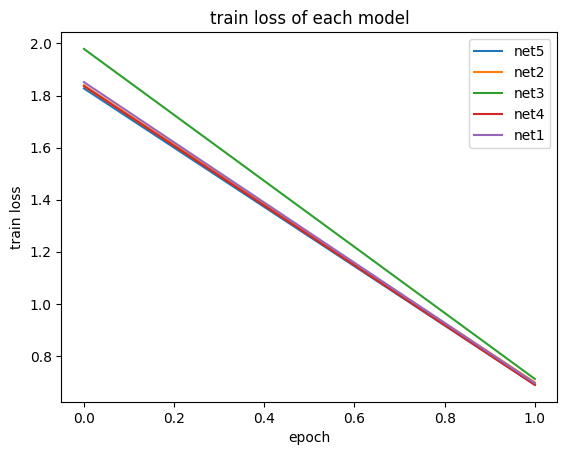

In [20]:
# plot each model's train loss in the same figure
plt.figure()
for i in range(train_l_avg.shape[0]):
    plt.plot(train_l_avg[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title('train loss of each model')
# plt.savefig(os.path.join(data_dir, 'train_loss.png'))
plt.show()

#### energy_data

In [21]:
energy_data_matrix = np.zeros((len(energy_data_files), epoch_num, 1), dtype=object)
for energy_data_file in energy_data_files:
    energy_data = np.load(energy_data_file, allow_pickle=True)
    # print(energy_data)
    energy_data_matrix[energy_data_files.index(energy_data_file),:, :] = energy_data
print(energy_data_matrix)

[[[list([9558, 10153, 10936, 9748, 9962, 9462, 9155, 9882, 9554, 9273, 9553, 11449, 10000, 9091, 10066, 9602, 9314, 9687, 10638, 9464, 9098, 10471, 10471, 10014, 9701, 10158, 10054, 10611, 10926, 10664, 11951, 12477, 9707, 9427, 9804, 9985, 9604, 9801, 12703, 10168, 11154, 12388, 10963, 10086, 9586, 9316, 9902, 10427, 9914, 9562, 9843, 10080, 9700, 9793, 9513, 9879, 9641, 9193, 9676, 9901, 9662, 11304, 10040, 9690, 9391, 9331, 9879, 9733, 9093, 9925, 10926, 9219, 8473, 9220, 9458, 9165, 7993, 8987, 9267, 9090, 8160, 8750, 9231, 9162, 8343, 8597, 9097, 8718, 8679, 8319, 9669, 10922, 8692, 8170, 9129, 9307, 8603, 7964, 9132, 9141, 10736, 8692, 8823, 9152, 8742, 8430, 8569, 9160, 8707, 8651, 8467, 9582, 8943, 8627, 8587, 9046, 8754, 8622, 8311, 9207, 11333, 8954, 8127, 9833, 9684, 9841, 8693, 9198, 9816, 10987, 8740, 10222, 9114, 8869, 8708, 8693, 9034, 8818, 8678, 8474, 9187, 9171, 8850, 8969, 9501, 9352, 9102, 8507, 9478, 9196, 11259, 8056, 9028, 9364, 8845, 8037, 9071, 9091, 9106, 9577

In [22]:
energy_data_avg = np.zeros((energy_data_matrix.shape[0], energy_data_matrix.shape[1]))
for i in range(energy_data_matrix.shape[0]):
    devicei_energy = energy_data_matrix[i, :, :]
    for j in range(devicei_energy.shape[0]):
        devicei_energy_epochi = np.array(devicei_energy[j, :][0])
        # print(devicei_energy_epochi)
        devicei_energy_epochi_mean = np.mean(devicei_energy_epochi)    
        # print(devicei_energy_epochi_mean)
        energy_data_avg[i, j] = devicei_energy_epochi_mean    
print(energy_data_avg)
        
    

[[ 9853.8685567  10578.81413613]
 [ 9137.18159806  9491.61728395]
 [14465.60659898 13929.81308411]
 [11732.66839378 11129.99473684]
 [10659.4963145  10827.47699758]]


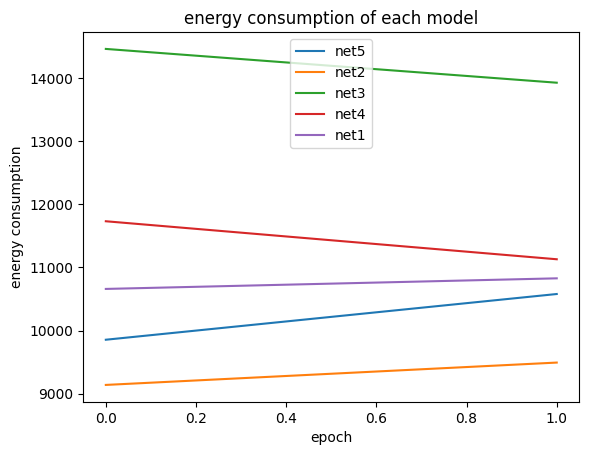

In [23]:
# plot each model's energy consumption in the same figure
plt.figure()
for i in range(energy_data_avg.shape[0]):
    plt.plot(energy_data_avg[i, :], label=data_folder[i])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('energy consumption')
plt.title('energy consumption of each model')
# plt.savefig(os.path.join(data_dir, 'energy_consumption.png'))
plt.show()